# Lab 10: RL: Policy Gradient Methods

This lab explores **reinforcement learning (RL)** techniques for learning control policies. We progress from simple policy gradient methods to advanced algorithms, applying them to increasingly complex control tasks.

## Overview of Tasks

**Task 1: REINFORCE on GridWorld**: Implement the REINFORCE algorithm, a Monte-Carlo policy gradient method. We train a neural network policy using one-hot state encoding to navigate a 5×5 grid while avoiding obstacles and reaching a goal. This task will directly use `Pytorch` libabary to create neural networks.

**Task 2: PPO on Continuous Control (Pendulum)**: Apply Proximal Policy Optimization (PPO) from Stable Baselines3 to the pendulum swing-up problem. PPO offers more stable learning than REINFORCE through variance reduction.

**Task 3: CartPole Stabilization**: Use PPO with custom wrappers to convert the discrete CartPole environment to continuous control. We learn a stabilization policy similar to LQR control, then extend it to handle larger initial conditions.

**Task 4: CartPole Swing-Up**: Train a policy to swing the pole from the downward position to upright. This demonstrates how RL can solve complex non-linear control problems without explicit trajectory optimization.

**Task 5: Hybrid Policy (Swing-Up + Stabilization)**: Combine the swing-up and stabilization policies using a mode-switching strategy. The agent swings up using one policy, then switches to a stabilizer policy once near the goal—demonstrating hybrid control.

## Task1: REINFORCE on a Grid Environment

This task introduces the policy gradient method: REINFORCE algorithm. We will use the same environment file (the GridWorld class) as defined in Lab 9. For policy learning, it is better that we randomize the starting position, instead of always starting at (0,0) as in Lab 9. This ensures the agent experiences all parts of the grid during training. If we always start from (0,0), the agent only learns a good policy for states along the path from (0,0) to the goal — it may never visit other cells and thus never learn what to do there. By randomizing the starting position, every cell gets visited, and the agent learns a complete policy for the entire grid. This becomes essential for larger and more complex environments, where a fixed starting position would leave most states unexplored.

Check the `reset` method in the GridWorld class to see how we randomize the starting position.

In [3]:
# @title
import gymnasium as gym
from gymnasium import spaces # spaces are used to define action and observation spaces
import numpy as np

# Define the set of possible actions and their visual representations
ACTIONS = [0, 1, 2, 3, 4]  # up, right, down, left, stay
ACTION_ARROWS = {0:"↑", 1:"→", 2:"↓", 3:"←", 4:"*"}


class GridWorld(gym.Env):

    """Custom GridWorld environment compatible with Gymnasium API.
    Note that Gymnasium environments are typically implemented as classes that inherit from gym.Env.
    This allows them to integrate seamlessly with the Gymnasium framework,
    which provides tools for reinforcement learning research and development.
    """

    def __init__(self,
                 grid_shape=(5, 5),
                 forbidden=None,
                 goal=None,
                 goal_reward=10.0,
                 step_reward=-0.01,
                 forbidden_reward=-5.0,
                 boundary_reward=-1.0,
                 render_mode=None):
        """
        Initializes the GridWorld environment.

        Args:
            grid_shape (tuple): The shape of the grid (rows, columns).
            forbidden (list of tuples): A list of coordinates for forbidden states.
            goal (tuple): The coordinates of the goal state.
            goal_reward (float): The reward for reaching the goal.
            step_reward (float): The reward for a regular step.
            forbidden_reward (float): The reward for entering a forbidden state.
            boundary_reward (float): The reward for hitting a boundary.
            render_mode (str, optional): The mode for rendering the environment.
        """
        super().__init__()

        self.grid_shape = grid_shape
        # Default locations for forbidden cells and the goal if not provided
        self.forbidden = forbidden if forbidden is not None else [(1,1), (1,2),(3,1), (3,3) ,(4,1)]
        # Example forbidden positions
        self.goal = goal if goal is not None else (3,2)
        # Example goal position

        # Reward structure
        self.goal_reward = goal_reward
        self.step_reward = step_reward
        self.forbidden_reward = forbidden_reward
        self.boundary_reward = boundary_reward

        # Discount factor
        self.render_mode = render_mode

        # Agent's current position, initialized in reset()
        self.agent_pos = None

        # Define Gymnasium spaces
        # The action space is discrete with a size equal to the number of actions.
        self.action_space = spaces.Discrete(len(ACTIONS))
        # The observation space represents the agent's position on the grid.
        self.observation_space = spaces.MultiDiscrete(list(grid_shape))


    def in_bounds(self, s):
        """Check if a state 's' is within the grid boundaries."""
        r, c = s
        R, C = self.grid_shape
        return 0 <= r < R and 0 <= c < C

    def is_forbidden(self, s):
        """Check if a state 's' is a forbidden state."""
        return s in self.forbidden

    def states(self):
        """Return a list of all possible states (coordinates) in the grid."""
        valid_states = []
        R, C = self.grid_shape
        for r in range(R):
            for c in range(C):
                valid_states.append((r,c))
        return valid_states

    def reset(self, seed=None, options=None):
        """
        Reset the environment to a RANDOM valid position.
        """
        super().reset(seed=seed)

        # Loop until we find a valid starting position
        while True:
            # Randomly pick a row and column
            r = np.random.randint(self.grid_shape[0])
            c = np.random.randint(self.grid_shape[1])
            s = (r, c)

            # Ensure we don't start in a forbidden cell or on the goal
            # if not self.is_forbidden(s) and s != self.goal:
            #     self.agent_pos = s
            #     break
            if s != self.goal:
                self.agent_pos = s
                break

        obs = np.array(self.agent_pos, dtype=np.int32)
        return obs, {}

    def step(self, action):
        """
        Execute one timestep in the environment.
        The agent takes an action, and the environment transitions to a new state.

        Args:
            action (int): The action to be taken by the agent.

        Returns:
            tuple: A tuple containing the new observation, the reward,
                   a boolean indicating if the episode is terminated,
                   a boolean indicating if the episode is truncated,
                   and an info dictionary.
        """
        assert self.action_space.contains(action), f"Invalid action {action}"

        r, c = self.agent_pos

        # Map the action to a new position (nr, nc for new row, new col)
        if action == 0:    nr, nc = r - 1, c     # up
        elif action == 1:  nr, nc = r, c + 1     # right
        elif action == 2:  nr, nc = r + 1, c     # down
        elif action == 3:  nr, nc = r, c - 1     # left
        else:              nr, nc = r, c         # stay

        # Check for environment boundaries
        terminated, truncated, info = False, False, {}
        next_pos = (nr, nc)
        if not self.in_bounds(next_pos):
            next_pos = self.agent_pos  # Agent stays in the same position
            reward = self.boundary_reward
        elif self.is_forbidden(next_pos):
            # next_pos = self.agent_pos  # Agent stays in the same position
            reward = self.forbidden_reward
        elif next_pos == self.goal:
            reward = self.goal_reward
            terminated = True
        elif action == 4:
            reward = -1
        else:
            reward = 0

        # Update the agent's position
        self.agent_pos = next_pos

        # Prepare the return values
        obs = np.array(self.agent_pos, dtype=np.int32)

        return obs, reward, terminated, truncated, info

    def render(self, P, V=None, ax=None, show=True):
        """
        Renders the greedy policy as arrows and overlays the value for each state in a matplotlib plot.
        This function will be used as a class method for the env class.

        Args:
            P (dict): The policy mapping states (r, c) to actions (int).
            V (dict): Optional. A dictionary mapping states to their values.
            ax: Optional matplotlib axes object. If provided, plots on this axes instead of creating a new figure.
            show (bool): Whether to call plt.show() at the end. Default True. Set False when creating subplots.

        Returns:
            tuple: (fig, ax) - The figure and axes objects.
        """
        import matplotlib.pyplot as plt
        import numpy as np

        R, C = self.grid_shape
        if ax is None:
            fig, ax = plt.subplots(figsize=(7, 6))
        else:
            fig = ax.figure
        ax.set_xlim(-0.5, C - 0.5)
        ax.set_ylim(-0.5, R - 0.5)
        ax.set_xticks(np.arange(-0.5, C, 1))
        ax.set_yticks(np.arange(-0.5, R, 1))
        ax.grid(True, color='gray', linewidth=1, linestyle='-')
        ax.set_aspect('equal')
        ax.invert_yaxis()  # Match array indexing

        # Draw cell highlights for forbidden/goal/start
        for r in range(R):
            for c in range(C):
                s = (r, c)
                if self.is_forbidden(s):
                    rect = plt.Rectangle((c-0.5, r-0.5), 1, 1, color='gray', alpha=0.5)
                    ax.add_patch(rect)
                    ax.text(c, r, "X", ha='center', va='center', color='black', fontsize=14)
                elif s == self.goal:
                    rect = plt.Rectangle((c-0.5, r-0.5), 1, 1, color='yellow', alpha=0.45)
                    ax.add_patch(rect)
                    ax.text(c, r, "G", ha='center', va='center', color='black', fontsize=14)

        # Print arrows and values in every cell (except forbidden)
        for r in range(R):
            for c in range(C):
                s = (r, c)
                # Print policy arrow
                if (r, c) in P:
                    arrow = ACTION_ARROWS[P[(r, c)]]
                else:
                    arrow = ""
                if (V is not None) and ((r, c) in V):
                    valstr = f"{V[(r, c)]:.2f}"
                else:
                    valstr = ""

                # Place arrow in cell
                ax.text(
                    c, r-0.18, arrow,
                    ha='center', va='center', color='darkblue', fontsize=22, fontweight='bold', zorder=10
                )

                ax.text(
                    c, r+0.22, valstr,
                    ha='center', va='center', color='crimson', fontsize=11, alpha=0.99,
                    zorder=10
                )

        # Label grid
        for x in range(C):
            ax.text(x, -0.75, str(x), ha='center', va='center', color='black')
        for y in range(R):
            ax.text(-0.75, y, str(y), ha='center', va='center', color='black')

        ax.set_title("Policy and Values")
        ax.tick_params(bottom=False, left=False, right=False, top=False,
                      labelbottom=False, labelleft=False, labeltop=False, labelright=False)
        if show:
            plt.tight_layout()
            plt.show()

        return fig, ax

### REINFORCE (Monte-Carlo Policy Gradient)

The REINFORCE algorithm directly learns a stochastic policy $\pi(a \mid s)$. It updates the policy so that actions leading to high returns become more likely, and actions leading to low returns become less likely.

**Parameterizing the Policy**

We use a neural network with parameters $\theta$ to represent the policy. The network outputs **logits** — raw, unnormalized scores for each action. These logits are then converted to a probability distribution using softmax:
$$
\pi_\theta(a \mid s) = \frac{\exp(f_\theta(s, a))}{\sum_{a'} \exp(f_\theta(s, a'))}
$$
where $f_\theta(s, a)$ is the network's output (logit) for action $a$ in state $s$.

**Why logits instead of direct action probabilities or actions?** Logits provide numerical stability, allow flexible real-valued outputs that softmax normalizes into valid probabilities, enable efficient gradient computation through `log_prob()`, and naturally support exploration by sampling from a distribution rather than greedily selecting a single action.

In our GridWorld:
- each state is a grid cell (r, c), represented using one-hot encoding
- available actions: up, right, down, left, stay
- the policy samples actions using these probabilities

The algorithm is like the following:

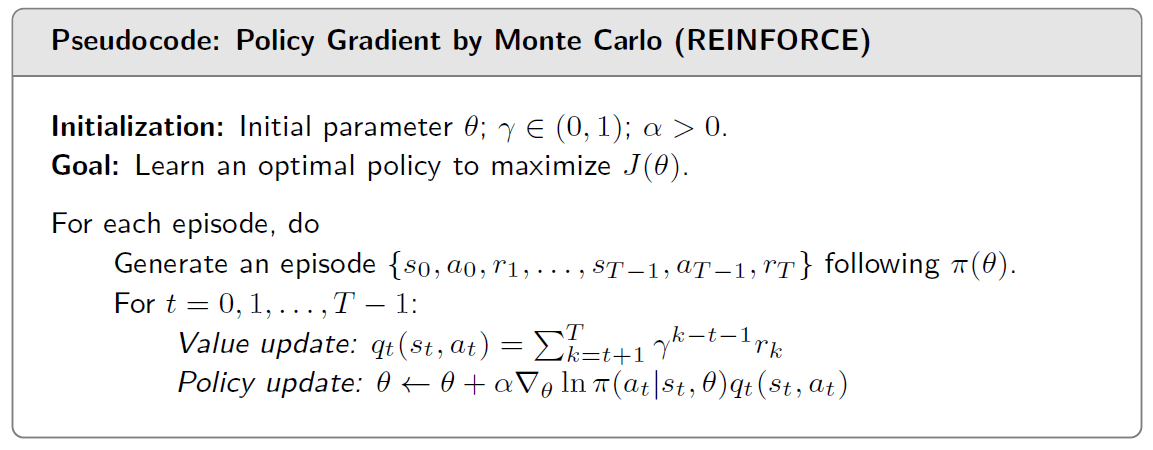

**Generating an Episode**

Starting from a start state $s_0$, the agent repeatedly:samples an action $a_t \sim \pi_\theta(a \mid s_t)$; transitions to the next state $s_{t+1}$ via the environment; receives reward $r_{t+1}$. This creates a trajectory:
$\{s_0, a_0, r_1, s_1, a_1, r_2, \dots, s_{T-1}, a_{T-1}, r_T\}$. The episode ends when the agent reaches the goal or when a step limit is reached.


**Action value update using Monte-Carlo Return**

For each timestep $t$, the action value is the cumulative discounted reward from that point onward:

$$
q_t(s_t,a_t)=G_t = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \cdots + \gamma^{T-t-1} r_{T}= \sum_{k=t+1}^{T} \gamma^{k-t-1} r_{k}
$$

In our GridWorld, we can set the following (you can change this to other values)
- reward +10 for reaching the goal  
- reward -10 for entering forbidden cells  
- reward -1 for hitting walls  
- reward -0.01 for each step  

**Policy Gradient Update**

REINFORCE increases the probability of actions that produced high returns. The policy gradient theorem gives us:
$$
\theta \leftarrow \theta + \alpha \nabla_\theta \ln \pi(a_t \mid s_t, \theta)\, q_t(s_t, a_t)
$$

where $\alpha$ is the learning rate. Note that the gradient $\nabla_\theta \ln \pi(a_t \mid s_t, \theta)$ can be directly computed is a neural network is used for the policy. In this case, the log-probability $\ln \pi(a_t \mid s_t, \theta)$
is differentiable with respect to the network parameters $\theta$, so automatic differentiation (backpropagation) provides the gradient without requiring any manual derivation.

-----
We use a neural network to represent the policy. The policy takes the current state as input and produces the probabilities of each action as the output. Intuitively, we might use the raw state coordinates, e.g., (0,1) or (0,3), as the input to the policy network. However, we use one-hot encoding on the state instead — so (0,1) becomes [0,1,0,0,0,...,0] and (0,3) becomes [0,0,0,1,0,...,0] — since raw coordinates make learning difficult for REINFORCE. The following section explains why.

**What is One-Hot Encoding?**

One-hot encoding represents a categorical value as a binary vector where only one element is 1 and all others are 0.

For our 5×5 GridWorld, each cell/state becomes a vector of length 25:

| State | Index | One-hot vector |
|-------|-------|----------------|
| (0,0) | 0 | [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] |
| (0,1) | 1 | [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] |
| (2,3) | 13 | [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0] |

**Why One-Hot Encoding Helps**

With raw coordinates `[2,3]` vs `[3,2]`, the network sees these as similar inputs — both contain a 2 and a 3. The network has to figure out that swapping row and column completely changes which cell we're in. This is hard to learn.

With one-hot encoding, every cell has its own unique "slot" in the input vector. Cell (2,3) lights up position 13, while cell (3,2) lights up position 17. There's no confusion — the network sees completely different inputs for different cells.

This is especially useful — and often necessary — for basic algorithms like REINFORCE. Because REINFORCE has high variance and no value function to stabilize learning, it struggles when the input representation is ambiguous. One-hot encoding removes this ambiguity, allowing the simple policy network to learn effectively. For this 5×5 GridWorld environment, REINFORCE struggles to converge without one-hot encoding.

**Tradeoff**

One-hot encoding works well for small discrete spaces like our 5×5 grid. For larger spaces (e.g., 100×100 grid or continuous states), it becomes impractical — that's when you need raw coordinates with more sophisticated learning algorithms.

In [4]:
import torch # PyTorch library for building and training neural networks
import torch.nn as nn # Neural network module from PyTorch
import torch.optim as optim # Optimization algorithms from PyTorch

# Create a function to convert state to one-hot:
def state_to_onehot(state, grid_shape=(5, 5)):
    """Convert (row, col) to one-hot vector"""
    r, c = state
    index = r * grid_shape[1] + c  # Flatten to single index
    onehot = torch.zeros(grid_shape[0] * grid_shape[1])
    onehot[index] = 1.0
    return onehot.unsqueeze(0)

LR = 0.0003 # Learning rate
GAMMA = 0.99 # Discount factor
EPISODES = 20000 # Number of training episodes
MAX_STEPS = 50 # Max steps per episode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#----------------------------------------------
# Initialize environment, policy network, and optimizer
#-----------------------
env = GridWorld()

state_dim = env.grid_shape[0] * env.grid_shape[1]  # state dimensions: 25 for 5x5 grid
action_dim = env.action_space.n # action dimensions: 5 actions

# Define policy network using nn.Sequential
# Input: 25-dimensional one-hot vector
# Output: 5 logits (one per action)
# Architecture: Linear(25 → 128) → ReLU → Linear(128 → 5)
policy_net = nn.Sequential(
    nn.Linear(state_dim, 128),
    nn.ReLU(),
    nn.Linear(128, action_dim)
).to(device)

# Define optimizer which is used to update the policy network parameters
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
return_list = []

#----------------------------------------------
# Training loop
#----------------------------------------------
print("Training started...")
for episode in range(EPISODES):
    log_probs = []
    rewards = []

    state, info = env.reset()
    episode_return = 0

    # Generate an episode
    for t in range(MAX_STEPS):
        state_tensor = state_to_onehot(state, env.grid_shape).to(device)

        # Get action logits from policy network
        # logits = [f_θ(s,0), f_θ(s,1), ..., f_θ(s,4)] are raw scores for each action
        logits = policy_net(state_tensor)

        # Categorical(logits=logits) applies softmax internally:
        # π_θ(a|s) = exp(f_θ(s,a)) / Σ_a' exp(f_θ(s,a'))
        # This converts logits into a valid probability distribution over actions
        action_dist = torch.distributions.Categorical(logits=logits)

        # Sample an action from the distribution π_θ(a|s)
        action = action_dist.sample()

        # Compute log π_θ(a_t|s_t) for the sampled action (needed for policy gradient)
        log_prob = action_dist.log_prob(action)

        # Take the action in the environment
        next_state, reward, terminated, truncated, _ = env.step(action.item())

        # Store log probability and reward
        log_probs.append(log_prob)
        rewards.append(reward)

        # Move to the next state
        state = next_state
        # Accumulate episode return
        episode_return += reward

        if terminated or truncated:
            break

    # Compute action values (returns) G_t for each time step t
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + GAMMA * G
        returns.insert(0, G)
    # Convert returns to tensor
    returns = torch.tensor(returns, dtype=torch.float32).to(device)

    # Compute loss -Σ log π(a_t|s_t) * G_t
    loss = 0
    for log_prob, G_t in zip(log_probs, returns):
        loss += -log_prob * G_t # loss is a tensor in PyTorch since log_prob is a tensor

    # Update policy (i.e., update the parameters of the policy network)
    optimizer.zero_grad() # Clear previous gradients
    loss.backward() # Backpropagate to compute gradients (since loss is a tensor, it has a .backward() method)
    optimizer.step() # Update policy network parameters

    return_list.append(episode_return)

    if (episode+1) % 1000 == 0:
        print(f"Episode {episode+1}/{EPISODES}, Return: {episode_return:.2f}")

Training started...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Episode 1000/20000, Return: -19.00
Episode 2000/20000, Return: -4.00
Episode 3000/20000, Return: 0.00
Episode 4000/20000, Return: 8.00
Episode 5000/20000, Return: 10.00
Episode 6000/20000, Return: 10.00
Episode 7000/20000, Return: 3.00
Episode 8000/20000, Return: 10.00
Episode 9000/20000, Return: 10.00
Episode 10000/20000, Return: 10.00
Episode 11000/20000, Return: 10.00
Episode 12000/20000, Return: 10.00
Episode 13000/20000, Return: 10.00
Episode 14000/20000, Return: 10.00
Episode 15000/20000, Return: 10.00
Episode 16000/20000, Return: 10.00
Episode 17000/20000, Return: 5.00
Episode 18000/20000, Return: 3.00
Episode 19000/20000, Return: 10.00
Episode 20000/20000, Return: 10.00


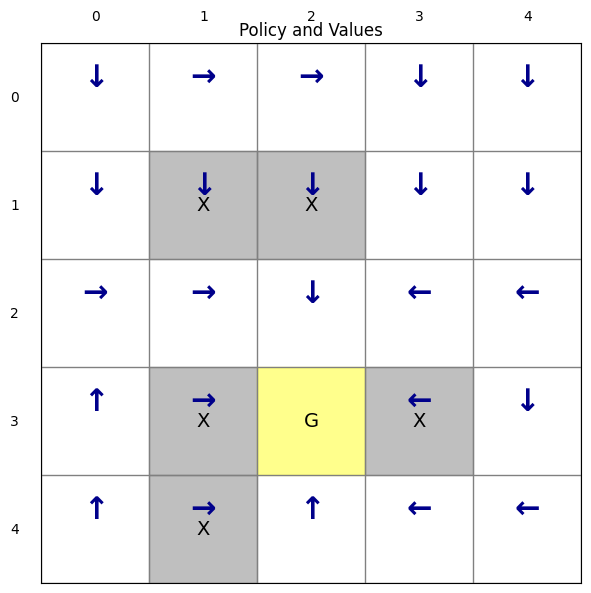

(<Figure size 700x600 with 1 Axes>,
 <Axes: title={'center': 'Policy and Values'}>)

In [3]:
# Visualization
policy_dict = {}
with torch.no_grad():
    for r in range(env.grid_shape[0]):
        for c in range(env.grid_shape[1]):
            s = (r, c)
            if s == env.goal:
                continue

            s_tensor = state_to_onehot(s, env.grid_shape).to(device)

            logits = policy_net(s_tensor)
            best_action = torch.argmax(logits).item()
            policy_dict[s] = best_action

env.render(policy_dict)


### RL using PPO (Proximal Policy Optimization)

The REINFORCE is simple and intuitive, which can be used to illustrate the basic concepts. We use it to illustrate how to use `Pytorch` to create neural networks. But REINFORCE generally suffers from high variance — the returns can vary significantly between episodes, making learning unstable and slow. Nowadays people normally used more advanced agorithms such as PPO (Proximal Policy Optimization) that addresses this issue. It uses a value function to reduce variance and includes a clipping mechanism to prevent overly large policy updates, resulting in more stable and efficient learning.

Instead of implementing PPO from scratch, we will use [Stable Baselines3 (SB3)](https://stable-baselines3.readthedocs.io/), a popular library that provides reliable implementations of many reinforcement learning algorithms, including PPO, A2C, DQN, and more. With SB3, we can train an agent in just a few lines of code.

Colab comes with many commonly used libraries preinstalled—such as NumPy, PyTorch, pandas, and FFmpeg—but Stable Baselines3 is not included by default. So we need to install it manually using the command `!pip install stable_baselines3`.

In [5]:
try:
    import stable_baselines3
except ImportError:
    !pip install stable_baselines3
    import stable_baselines3

# With the SB3 library and a Gymnasium-compatible environment, training can be done in just a few lines of code.
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# 1. create the environment
env = GridWorld()


# 2. Initialize PPO model
policy_kwargs = dict(
    net_arch=[16]  # Single hidden layer with 16 neurons
)
model = PPO("MlpPolicy",  # Multi-layer perceptron policy
            env,  # the environment
            verbose=1,  # print out info during training
            gamma=0.99,  # discount factor, if not provided, default is 0.99
            learning_rate=1e-2,  # learning rate, if not provided, default is 3e-4
            policy_kwargs=policy_kwargs # policy network architecture: if this is not provided, default is [64, 64]
            )


# 3. Train model
model.learn(total_timesteps=50_000)
print("training finished")
model.save("ppo_gridworld")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 51.2     |
|    ep_rew_mean     | -54.1    |
| time/              |          |
|    fps             | 700      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 39.5        |
|    ep_rew_mean          | -35.8       |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017991526 |
|    clip_fraction        | 0.29        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.59       |
|    explained_variance   | -0.00408    |
|    learning_rate        | 0.

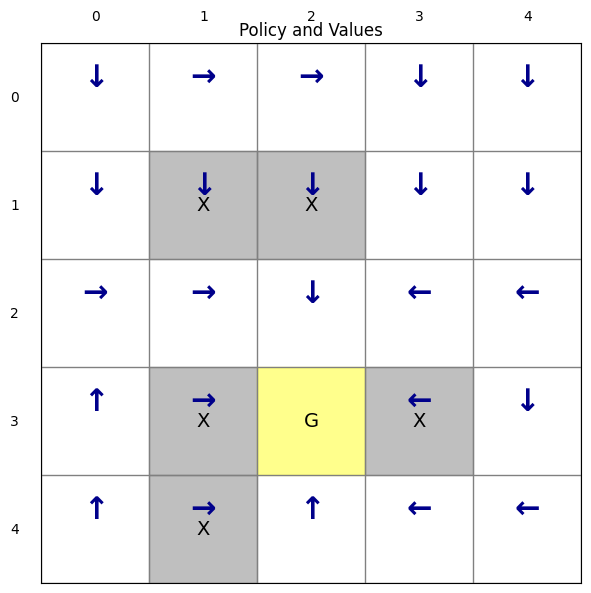

(<Figure size 700x600 with 1 Axes>,
 <Axes: title={'center': 'Policy and Values'}>)

In [5]:
## Now let us render the learned policy

# --- 1. Prepare to extract the policy ---
policy_dict = {}
R, C = env.grid_shape

# --- 2. Iterate over all states and find the best action ---
for r in range(R):
    for c in range(C):
        s = (r, c)

        # Skip the goal state, as no action is taken there
        if s == env.goal:
            continue

        # The input to the model's predict() must be a NumPy array.
        state_np = np.array([r, c], dtype=np.int32)

        # model.predict returns the action (0-4) and the hidden state (which we ignore)
        best_action, _ = model.predict(state_np, deterministic=True)

        # Store the greedy action for the state
        policy_dict[s] = int(best_action)

# --- 3. Render the policy ---
env.render(policy_dict)

The rendered policy shows that PPO successfully learns an optimal policy for each state, efficiently reaching the goal while avoiding forbidden cells. The training results are also consistent across runs.

## Task 2: RL for the Torque-Limited Pendulum

Lets continue the reinforcement learning on a more complicated environment provided by Gymnasium, the [Pendulum](https://gymnasium.farama.org/environments/classic_control/pendulum/).

![the pendulum](https://gymnasium.farama.org/_images/pendulum.gif)

The pendulum swingup problem is similar to what we have investigated before in previous labs (such as trajectory optimization). The system consists of a pendulum attached at one end to a fixed point, and the other end being free. The pendulum starts in a random position and the goal is to apply torque on the pendulum to swing it up into an upright position, with its center of gravity right above the fixed point.

If we use SB3 and the PPO algorithm, the training code for the Pendulum environment is very similar to what we used for GridWorld. This is the beauty of the Gymnasium API — once an environment follows the standard interface (reset, step, observation_space, action_space, render), the same training code works on various environments with minimal changes. Whether the environment is a simple grid, a physics simulation, or a complex game, SB3 handles it seamlessly. This modularity makes it easy to experiment with different environments without rewriting the training loop.

In [10]:
import imageio # for creating videos
import gymnasium as gym # Gymnasium library for reinforcement learning environments
from stable_baselines3 import PPO # PPO algorithm
from stable_baselines3.common.env_util import make_vec_env # for creating vectorized environments
import numpy as np
from IPython.display import Video # for displaying videos in Jupyter notebooks

# 1. Create training env
# Pendulum-v1 comes from Gymnasium's built-in environments
env = make_vec_env("Pendulum-v1", n_envs=4)

# 2. Train PPO model
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    gamma=0.99,
)

model.learn(total_timesteps=100_000) # the number of training timesteps can be adjusted

# 3. Save the trained model
model.save("ppo_pendulum_v1")
print("Training finished and model saved.")

Using cuda device


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.23e+03 |
| time/              |           |
|    fps             | 3007      |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 8192      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 200          |
|    ep_rew_mean          | -1.24e+03    |
| time/                   |              |
|    fps                  | 1447         |
|    iterations           | 2            |
|    time_elapsed         | 11           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0033566756 |
|    clip_fraction        | 0.0186       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -0.00278     |
|    

Now that training is complete, we can evaluate the learned policy.
The most intuitive way to do this is to run a full episode with the trained agent, record its behavior, and watch the video. This gives us a direct sense of how well the agent behaves.

In Gymnasium-compatible environments, video recording is supported through the render() method, which allows us to capture each frame as the agent interacts with the environment. By saving these frames, we can create a short animation of the agent’s trajectory and assess the quality of the learned policy visually.

In [11]:
# Create rendering env
render_env = gym.make(
    "Pendulum-v1",
    render_mode="rgb_array", # to enable image rendering
    max_episode_steps=3000
)

# Load the trained model in the previous cell
model = PPO.load("ppo_pendulum_v1")

# Record video using the imageio library
writer = imageio.get_writer("pendulum_video.mp4", fps=30)

# Reset the environment
obs, info = render_env.reset()

# Run the trained model and record frames
for _ in range(300): # generate 300 frames
    action, _ = model.predict(obs, deterministic=True) # get action from the trained model
    obs, reward, terminated, truncated, info = render_env.step(action) # take action in env

    frame = render_env.render()
    writer.append_data(frame)

    if terminated or truncated:
        break

writer.close()
render_env.close()
Video("pendulum_video.mp4", embed=True, width=600)

SB3 allows you to customize many internal parameters of its algorithms. For example, you can modify the structure of the policy neural networks, adjust activation functions, or change other policy-related settings. These options are passed through the policy_kwargs argument.

```python
policy_kwargs = dict(
    net_arch=[256, 256]   # two hidden layers of size 256 each
)

model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    gamma=0.99,
    policy_kwargs=policy_kwargs
)
```

It is also useful to experiment with key hyperparameters—such as the learning rate and the entropy coefficient—when creating the PPO model. Adjusting these values can significantly influence exploration and training stability.

**Guidelines for choosing hyperparameters:**

- **Learning rate (`learning_rate`)**: Controls how quickly the policy is updated. Typical values range from 1e-5 to 1e-2. Start with 3e-4 (the default) and decrease if training is unstable or increase if learning is too slow.

- **Discount factor (`gamma`)**: Determines how much future rewards are valued. Use values close to 1.0 (e.g., 0.95–0.99) for tasks requiring long-term planning, and lower values (e.g., 0.9) for tasks with immediate rewards.

- **Entropy coefficient (`ent_coef`)**: Encourages exploration by adding randomness to the policy. Use small positive values (e.g., 0.01–0.1) to promote exploration early in training, or 0.0 if the agent already explores sufficiently.

- **Network architecture (`net_arch`)**: Larger networks (e.g., [256, 256]) can model complex policies but may overfit or train slowly. Smaller networks (e.g., [64, 64]) are faster and work well for simpler tasks. Adjust based on task complexity.

Tuning these parameters often requires experimentation. Start with defaults, observe training behavior, and adjust one parameter at a time based on performance and stability.

```python
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    gamma=0.99,
    ent_coef = 0.01
)
```

## Task 3: Learning to stabilize the Cart Pole system

We have used model-based approach (e.g., LQR) to stabilize the cart pole system in previous labs. Now let's try to use RL to stabilize it. For the cart-pole system, a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pole is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart. The detailed description for the system can be found at https://gymnasium.farama.org/environments/classic_control/cart_pole/. The code implementation for the Cart-Pole Dynamics can be found here: [Cart-Pole System](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py)


The default Gym CartPole environment (e.g., CartPole-v1) is a stabilization task: the pole starts nearly upright, and the objective is to keep it balanced while keeping the cart near the center. Since the goal is to keep the pole upright for as long as possible, by default, a reward of +1 is given for every step taken, including the termination step.  An episode terminates when the pole falls beyond a small angle or the cart moves too far from the origin. We will learn to swing-up the pole in the next task.

For this environment provided by Gymnasium, the default action discrete. In fact, is a ndarray with shape (1,) which can take values {0, 1} indicating the direction of the fixed force applied horizontly on the cart.

- 0: Push cart to the left
- 1: Push cart to the right

In [ ]:
import imageio
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import numpy as np
from IPython.display import Video


# 1. Create training env
env = make_vec_env("CartPole-v1", n_envs=1) #n_envs=1 means no vectorization

# 2. Train PPO model
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    gamma=0.99,
)

model.learn(total_timesteps=300_000)

# Save model
model.save("ppo_CartPole_v1")
print("Training finished and model saved.")

In [ ]:
# 3. Create rendering env
render_env = gym.make(
    "CartPole-v1",
    render_mode="rgb_array",
    max_episode_steps=2000
)

# Load model
model = PPO.load("ppo_CartPole_v1")

# 4. Record video
writer = imageio.get_writer("pendulum_video.mp4", fps=30)

obs, info = render_env.reset()

for _ in range(300):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = render_env.step(action)

    frame = render_env.render()
    writer.append_data(frame)

    if terminated or truncated:
        break

writer.close()
render_env.close()
Video("pendulum_video.mp4", embed=True, width=600)

### Using Wrappers to covnert discrete actions to continous actions

Now we can try to revise the default setting to make it similar to model-based approach. To do this, we will do two things through the wrapper of gym:

- Convert the problem to be continuous
- Use a new reward function similar to the cost function we have used in trajectory optimization

**What is a Gym [Wrapper](https://gymnasium.farama.org/introduction/basic_usage/#modifying-the-environment)?**

A wrapper is a design pattern that allows us to modify the behavior of an existing environment without creating an entirely new one from scratch. Wrappers "wrap around" the original environment and can modify:
- Action spaces (discrete → continuous)
- Observation spaces
- Reward functions
- Episode termination conditions
- Any other environment behavior

**Why Use Wrappers Instead of Creating New Environments?**
1. **Reusability**: We can apply the same modifications to different base environments
2. **Modularity**: Each wrapper handles one specific modification, making code more organized
3. **Maintainability**: Changes to the base environment automatically propagate to wrapped versions
4. **Efficiency**: We leverage the existing, well-tested Gymnasium implementation rather than reimplementing dynamics

In our case, we'll first use :
- `ContinuousCartPoleWrapper`: Converts discrete actions {0, 1} to continuous torque values

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces


class ContinuousCartPoleWrapper(gym.Wrapper):
    """
    Wrapper that turns CartPole-v1 into a continuous-control,
    LQR-style stabilization task.

    - Action: u in [-u_max, u_max]  (continuous force)
    - State:  [x, x_dot, theta, theta_dot]
    - Reward: r = -(x^T Q x + u^T R u) * dt, with optional terminal penalty.
    """

    def __init__(
        self,
        env: gym.Env,
        u_max: float = 10.0,
        Q: np.ndarray | None = None,
        R: float | None = None,
        scale_with_dt: bool = True,
        terminal_cost: float = 100.0,
    ):
        super().__init__(env)

        # Continuous 1D action (force)
        self.u_max = float(u_max)
        self.action_space = spaces.Box(
            low=np.array([-self.u_max], dtype=np.float32),
            high=np.array([self.u_max], dtype=np.float32),
            dtype=np.float32,
        )

        # Keep the original observation space (4-dim Box)
        self.observation_space = env.observation_space

        # Default LQR weights if not provided
        # Emphasize pole angle θ and cart position x
        if Q is None:
            # state = [x, x_dot, theta, theta_dot]
            Q = np.diag([1.0, 0.1, 10.0, 0.1])
        if R is None:
            R = 0.01  # scalar for u^2

        self.Q = np.array(Q, dtype=np.float64)
        self.R = float(R)

        self.scale_with_dt = scale_with_dt
        self.terminal_cost = float(terminal_cost)

    # Just delegate reset to inner env and return same observation
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        return obs, info

    def step(self, action):
        # ---- 1) Continuous control input u ----
        if isinstance(action, np.ndarray):
            u = float(action.squeeze())
        else:
            u = float(action)
        u = np.clip(u, -self.u_max, self.u_max)

        # Use the *unwrapped* CartPole to access physics params and state
        env = self.env.unwrapped

        # ---- 2) Current state ----
        x, x_dot, theta, theta_dot = env.state

        # ---- 3) Dynamics from Gymnasium's CartPole (but with continuous u) ----
        gravity = env.gravity
        masscart = env.masscart
        masspole = env.masspole
        total_mass = masscart + masspole
        length = env.length          # actually half the pole length
        polemass_length = masspole * length
        tau = env.tau                # time step

        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        # This is exactly CartPole's internal derivation, but with "force = u"
        temp = (u + polemass_length * theta_dot**2 * sintheta) / total_mass
        theta_acc = (gravity * sintheta - costheta * temp) / (
            length * (4.0 / 3.0 - masspole * costheta**2 / total_mass)
        )
        x_acc = temp - polemass_length * theta_acc * costheta / total_mass

        # Euler integration
        x = x + tau * x_dot
        x_dot = x_dot + tau * x_acc
        theta = theta + tau * theta_dot
        theta_dot = theta_dot + tau * theta_acc

        env.state = (x, x_dot, theta, theta_dot)

        # ---- 4) Termination condition (same as CartPole) ----
        terminated = (
            x < -env.x_threshold
            or x > env.x_threshold
            or theta < -env.theta_threshold_radians
            or theta > env.theta_threshold_radians
        )
        # We don't enforce a time limit here; TimeLimit wrapper can be applied outside if you like
        truncated = False

        """# ---- 5) LQR-like reward ----
        state_vec = np.array([x, x_dot, theta, theta_dot], dtype=np.float64)
        state_cost = state_vec @ self.Q @ state_vec
        control_cost = self.R * (u ** 2)

        cost = state_cost + control_cost
        if self.scale_with_dt:
            cost *= tau
        reward = -float(cost)
        """
        # ---- LQR-like reward with boundary shaping ----
        state_vec = np.array([x, x_dot, theta, theta_dot], dtype=np.float64)
        state_cost = state_vec @ self.Q @ state_vec
        control_cost = self.R * (u ** 2)

        # Soft barrier on cart position near limits
        x_norm = abs(x) / env.x_threshold  # 0 at center, 1 at boundary
        boundary_cost = 5.0 * (x_norm ** 4)  # smooth, grows steeply near boundary

        # Extra angle robustness term (helps with large initial angles)
        angle_cost = 0.5 * (1.0 - np.cos(theta)) * 20.0  # ~10 when upside down

        cost = state_cost + control_cost + boundary_cost + angle_cost
        if self.scale_with_dt:
            cost *= tau

        reward = -float(cost) # total reward is negative cost


        # Add terminal cost when it fails
        if terminated:
            reward -= self.terminal_cost

        # Add terminal cost when it fails
        if terminated:
            reward -= self.terminal_cost

        obs = state_vec.astype(np.float32)
        info = {
            "u": u,
            "state_vec": obs,
            "state_cost": state_cost,
            "control_cost": control_cost,
            "instant_cost": cost,
        }

        return obs, reward, terminated, truncated, info

    # For rendering, just delegate
    def render(self):
        return self.env.render()

With the wrapper, can can implement a continous version for the balance task.

In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Create the environment with continuous action wrapper
def make_env():
    base_env = gym.make("CartPole-v1")  # standard env
    env = ContinuousCartPoleWrapper(base_env, u_max=20.0)
    return env

env = make_vec_env(make_env, n_envs=1)

model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    gamma=0.99
)

model.learn(total_timesteps=150_000)
model.save("ppo_continuous_cartpole")

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.9     |
|    ep_rew_mean     | -200     |
| time/              |          |
|    fps             | 3111     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 40.1         |
|    ep_rew_mean          | -200         |
| time/                   |              |
|    fps                  | 2008         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0028058211 |
|    clip_fraction        | 0.0112       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.43        |
|    explained_variance   | -5.13e-05    

In [ ]:
import imageio
from IPython.display import Video

render_env = gym.make(
    "CartPole-v1",
    render_mode="rgb_array",  # important for frame capture
)
render_env = ContinuousCartPoleWrapper(render_env, u_max=20.0)

model = PPO.load("ppo_continuous_cartpole")

writer = imageio.get_writer("CartPole_LQR.mp4", fps=30)

obs, info = render_env.reset()
for _ in range(300):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = render_env.step(action)

    frame = render_env.render()
    writer.append_data(frame)

    if terminated or truncated:
        break

writer.close()
render_env.close()

Video("CartPole_LQR.mp4", embed=True, width=600)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


From the video, you may notice that the motion of the cart pole does not vary too much. This is because in the default Gym env, the intial condition starts very close to the upright configuration. In fact:

```python
high = np.array([0.05, 0.05, 0.05, 0.05])
self.state = self.np_random.uniform(low=-high, high=high, size=(4,))
```

This means:

| State variable | Meaning                 | Initial range                |
|:--------------:|-------------------------|------------------------------|
| x              | cart position           | uniform in [-0.05, +0.05]    |
| x_dot          | cart velocity           | uniform in [-0.05, +0.05]    |
| theta          | pole angle              | uniform in [-0.05, +0.05] rad|
| theta_dot      | pole angular velocity   | uniform in [-0.05, +0.05]    |

And 0.05 rad ≈ 2.8° from vertical. This means the PPO agent is learning local stabilization very near the equilibrium.

Let's try to use another wrapper `WideInitWrapper` to train a policy that can handle large initial ranges.

In [ ]:
class WideInitWrapper(gym.Wrapper):
    """
    Reset with wider ranges so PPO sees large initial angles.
    Ranges are tunable.
    """
    def __init__(
        self,
        env,
        x_range=1, # range for cart position
        xdot_range=1, # range for cart velocity
        theta_range=np.pi/10, # range for pole angle (up to ±18°)
        thetadot_range=2.0, # range for pole angular velocity
    ):
        super().__init__(env)
        self.x_range = x_range
        self.xdot_range = xdot_range
        self.theta_range = theta_range
        self.thetadot_range = thetadot_range

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        rng = self.env.unwrapped.np_random

        x = rng.uniform(-self.x_range, self.x_range)
        x_dot = rng.uniform(-self.xdot_range, self.xdot_range)
        theta = rng.uniform(-self.theta_range, self.theta_range)
        theta_dot = rng.uniform(-self.thetadot_range, self.thetadot_range)

        self.env.unwrapped.state = (x, x_dot, theta, theta_dot)
        obs = np.array([x, x_dot, theta, theta_dot], dtype=np.float32)
        return obs, info

In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Create the environment with continuous action wrapper
def make_env():
    base = gym.make("CartPole-v1")
    base = ContinuousCartPoleWrapper(base, u_max=20.0)  # or ContinuousLQRCartPoleWrapper
    base = WideInitWrapper(base, theta_range=np.pi/10, thetadot_range=1.0)
    return base

env = make_vec_env(make_env, n_envs=4)

model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    gamma=0.99
)

model.learn(total_timesteps=500_000)
model.save("ppo_continuous_cartpole")

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.4     |
|    ep_rew_mean     | -200     |
| time/              |          |
|    fps             | 10222    |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 14.2        |
|    ep_rew_mean          | -200        |
| time/                   |             |
|    fps                  | 3908        |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.001263215 |
|    clip_fraction        | 0.00094     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | -6.63e-05   |
|    learning

In [ ]:
# Now render the trained model with wide init
import imageio
from IPython.display import Video

render_env = gym.make(
    "CartPole-v1",
    render_mode="rgb_array",  # important for frame capture
)
render_env = ContinuousCartPoleWrapper(render_env, u_max=20.0)
render_env = WideInitWrapper(render_env, theta_range=np.pi/10, thetadot_range=1.0)  # match training init

model = PPO.load("ppo_continuous_cartpole")

writer = imageio.get_writer("CartPole.mp4", fps=30)

obs, info = render_env.reset()
for _ in range(300):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = render_env.step(action)

    frame = render_env.render()
    writer.append_data(frame)

    if terminated or truncated:
        break

writer.close()
render_env.close()

Video("CartPole_LQR.mp4", embed=True, width=600)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Task 4: Learning Swing-up for the Cart Pole System

In this task, we train a RL agent to swing up a CartPole from the downward position to upright, then stabilize it. Unlike Task 3 (which focuses on stabilization from a near-upright starting position), this task addresses the more challenging swing-up problem.

**Goal**: Learn a policy that swings the pole from hanging down (θ ≈ π) to upright (θ ≈ 0) and keeps it balanced.

**Approach**:
1. Design a custom reward function that encourages upright orientation (cos(θ)) while penalizing cart displacement, velocities, and control effort
2. Use `ContinuousSwingUpCartPoleWrapper` to apply continuous forces and define success/failure conditions
3. Use `SwingUpInitWrapper` to initialize episodes with the pole near the downward position
4. Train PPO with appropriate hyperparameters and multiple parallel environments for stable learning
5. Visualize the learned behavior through video rendering

This demonstrates how RL can solve complex non-linear control problems without explicit trajectory optimization, learning a smooth swing-up motion purely from experience.

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces


class ContinuousSwingUpCartPoleWrapper(gym.Wrapper):
    """
    Continuous-action CartPole with swing-up style reward.

    - Action: u in [-u_max, u_max]
    - State:  [x, x_dot, theta, theta_dot]
    - Reward: encourage upright (cos(theta)) and penalize big x, velocities, and control.
    - Done:
        * success when near-upright for several consecutive steps
        * failure if cart goes out of bounds
        * episode time limit is handled by an outer TimeLimit wrapper.
    """

    def __init__(
        self,
        env: gym.Env,
        u_max: float = 10.0,  # max force
        x_fail_threshold: float = 2.4,  # cart position failure threshold
        upright_theta_thresh: float = np.deg2rad(12.0),  # setpoint for "upright"
        upright_theta_dot_thresh: float = 1.0,  # velocity threshold for "upright"
        upright_x_thresh: float = 0.5,  # position threshold for "upright"
        success_steps: int = 2,  # number of consecutive upright steps for success
        success_bonus: float = 50.0,  # reward for achieving upright
        failure_penalty: float = 50.0,  # penalty for failure
    ):
        super().__init__(env)

        # Continuous 1D action space
        self.u_max = float(u_max)
        self.action_space = spaces.Box(
            low=np.array([-self.u_max], dtype=np.float32),
            high=np.array([self.u_max], dtype=np.float32),
            dtype=np.float32,
        )

        # Same observation space as CartPole
        self.observation_space = env.observation_space

        # Swing-up termination thresholds
        self.x_fail_threshold = float(x_fail_threshold)
        self.upright_theta_thresh = float(upright_theta_thresh)
        self.upright_theta_dot_thresh = float(upright_theta_dot_thresh)
        self.upright_x_thresh = float(upright_x_thresh)

        # Success condition (must hold upright for N consecutive steps)
        self.success_steps = int(success_steps)
        self.steps_upright = 0  # counter

        self.success_bonus = float(success_bonus)
        self.failure_penalty = float(failure_penalty)

    def reset(self, **kwargs):
        # Let another wrapper handle initial conditions if present
        obs, info = self.env.reset(**kwargs)
        self.steps_upright = 0
        return obs, info

    def step(self, action):
        # ---- 1) Continuous control input u ----
        if isinstance(action, np.ndarray):
            u = float(action.squeeze())
        else:
            u = float(action)
        u = np.clip(u, -self.u_max, self.u_max)

        env = self.env.unwrapped

        # ---- 2) Current state ----
        x, x_dot, theta, theta_dot = env.state

        # ---- 3) Dynamics (same as CartPole, but with force = u) ----
        gravity = env.gravity
        masscart = env.masscart
        masspole = env.masspole
        total_mass = masscart + masspole
        length = env.length          # actually half pole length
        polemass_length = masspole * length
        tau = env.tau                # time step

        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        temp = (u + polemass_length * theta_dot**2 * sintheta) / total_mass
        theta_acc = (gravity * sintheta - costheta * temp) / (
            length * (4.0 / 3.0 - masspole * costheta**2 / total_mass)
        )
        x_acc = temp - polemass_length * theta_acc * costheta / total_mass

        # Euler integration
        x = x + tau * x_dot
        x_dot = x_dot + tau * x_acc
        theta = theta + tau * theta_dot
        theta_dot = theta_dot + tau * theta_acc

        env.state = (x, x_dot, theta, theta_dot)

        # ---- 4) Termination: success/failure ----
        # "Upright" region: near upright and reasonably calm
        upright = (
            abs(theta) < self.upright_theta_thresh
            and abs(theta_dot) < self.upright_theta_dot_thresh
            and abs(x) < self.upright_x_thresh
        )

        if upright:
            self.steps_upright += 1
        else:
            self.steps_upright = 0

        # Success if we've stayed upright long enough
        success = self.steps_upright >= self.success_steps

        # Failure: cart leaves the track
        failure = abs(x) > self.x_fail_threshold

        terminated = success or failure
        truncated = False  # TimeLimit wrapper outside can handle max steps

        # ---- 5) Swing-up reward ----
        # Main term: cos(theta) is highest at upright (1) and lowest at downward (-1)
        r_angle = np.cos(theta)

        # Penalize cart displacement
        r_x = -0.01 * (x**2)

        # Stronger penalty on angular velocity
        w_xdot = 0.01
        w_thetadot = 0.03
        r_vel = -(w_xdot * x_dot**2 + w_thetadot * theta_dot**2)

        # Penalize control effort
        r_u = -0.001 * (u**2)

        # Penalize approaching boundaries
        r_boundary = -5.0 * (abs(x) / self.env.unwrapped.x_threshold) ** 4

        reward = float(r_angle + r_x + r_vel + r_u + r_boundary)

        # Terminal bonuses/penalties
        if success:
            reward += self.success_bonus
        if failure:
            reward -= self.failure_penalty

        obs = np.array([x, x_dot, theta, theta_dot], dtype=np.float32)
        info = {
            "u": u,
            "upright": upright,
            "success": success,
            "failure": failure,
            "steps_upright": self.steps_upright,
        }

        return obs, reward, terminated, truncated, info

    def render(self):
        return self.env.render()

In [ ]:
class SwingUpInitWrapper(gym.Wrapper):
    """
    Override reset() so the pole starts near the downward position (theta ~ pi).
    """

    # define the angle noise in degrees, default is 10 degrees
    def __init__(self, env, angle_noise_deg: float = 10.0):
        super().__init__(env)
        self.angle_noise = np.deg2rad(angle_noise_deg)

    def reset(self, **kwargs):
        # Call base reset to set up RNG etc.
        obs, info = self.env.reset(**kwargs)

        rng = self.env.unwrapped.np_random

        x = 0.0
        x_dot = 0.0
        # Set theta near pi (downward) with some noise
        theta = np.pi + rng.uniform(-self.angle_noise, self.angle_noise)
        theta_dot = 0.0

        self.env.unwrapped.state = (x, x_dot, theta, theta_dot)

        obs = np.array([x, x_dot, theta, theta_dot], dtype=np.float32)
        return obs, info


Using cpu device
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 665       |
|    ep_rew_mean     | -1.01e+03 |
| time/              |           |
|    fps             | 8946      |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 4096      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 612         |
|    ep_rew_mean          | -994        |
| time/                   |             |
|    fps                  | 3436        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.003837293 |
|    clip_fraction        | 0.023       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.44       |
|    explained_variance   | 0.00455     |
|  

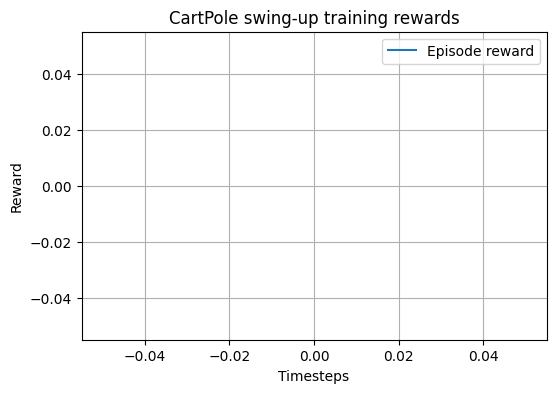

In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt


# 1) Build vectorized environment
def make_env():
    base_env = gym.make("CartPole-v1")
    base_env = Monitor(base_env, log_dir)   # <-- log episodic stats
    env = ContinuousSwingUpCartPoleWrapper(base_env, u_max=20.0)
    env = SwingUpInitWrapper(env, angle_noise_deg=15.0)
    return env

env = make_vec_env(make_env, n_envs=4)  # multiple envs helps PPO

# 2) Train PPO
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    gamma=0.99,
    n_steps=1024,
    batch_size=64,
)

model.learn(total_timesteps=1_000_000)
model.save("ppo_cartpole_swingup")
env.close()

In [ ]:
import imageio
from stable_baselines3 import PPO
from IPython.display import Video

# 1) Rebuild render env with same wrappers
render_env = gym.make(
    "CartPole-v1",
    render_mode="rgb_array",
    max_episode_steps=5000,   # allow enough time for swing-up
)

render_env = ContinuousSwingUpCartPoleWrapper(render_env, u_max=20.0)
render_env = SwingUpInitWrapper(render_env, angle_noise_deg=15.0)

# 2) Load trained model
model = PPO.load("ppo_cartpole_swingup")

# 3) Record video
writer = imageio.get_writer("CartPole_swingup.mp4", fps=30)

obs, info = render_env.reset()

for _ in range(5000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = render_env.step(action)

    frame = render_env.render()
    writer.append_data(frame)

    if terminated or truncated:
        break

writer.close()
render_env.close()

Video("CartPole_swingup.mp4", embed=True, width=600)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Task 5: Hybrid Policy to Swing Up and then Stay

In this task, we combine two trained PPO policies: a swing-up policy and a stabilizer policy. We run the environment with ContinuousSwingUpCartPoleWrapper (continuous force, swing-up reward/termination) and initialize near the downward position using SwingUpInitWrapper. During the episode, we start in “swingup” mode and switch to “stabilize” when the state meets the upright criteria. After switching, actions come from stabilizer_model; before switching, actions come from swingup_model. We record the full run to a video (combined_cartpole.mp4) to visualize the handoff and final stabilization.

In [ ]:
import numpy as np
import gymnasium as gym
import imageio
from stable_baselines3 import PPO
from IPython.display import Video


# ---------- 1. Upright condition used for switching ----------

# Tunable thresholds for the *handoff* to stabilizer
THETA_THRESH = np.deg2rad(3.0)   # ~3 degrees
THETA_DOT_THRESH = 1            # rad/s
X_THRESH = 0.7                    # meters


def is_upright(obs) -> bool:
    """
    Check if the current state is 'upright enough' to hand off
    from the swing-up policy to the stabilizer policy.

    obs = [x, x_dot, theta, theta_dot]
    """
    x, x_dot, theta, theta_dot = obs
    return (
        abs(theta) < THETA_THRESH
        and abs(theta_dot) < THETA_DOT_THRESH
        and abs(x) < X_THRESH
    )


# ---------- 2. Load trained models ----------
print("Loading models...")
swingup_model = PPO.load("ppo_cartpole_swingup")
stabilizer_model = PPO.load("ppo_continuous_cartpole")
print("Models loaded successfully")


# ---------- 3. Create evaluation environment ----------
render_env = gym.make(
    "CartPole-v1",
    render_mode="rgb_array",
    max_episode_steps=1000,
)

# Wrap with swing-up wrapper for physics
render_env = ContinuousSwingUpCartPoleWrapper(
    render_env,
    u_max=20.0,
    x_fail_threshold=2.4,
    success_steps=10**9,   # disable automatic success termination
)

# Start from downward position
render_env = SwingUpInitWrapper(render_env, angle_noise_deg=5.0)


# ---------- 4. Run combined episode and record video ----------
writer = imageio.get_writer("combined_cartpole.mp4", fps=30)

obs, info = render_env.reset()
mode = "swingup"
print(f"Starting episode in mode: {mode}")
print(f"Initial state: x={obs[0]:.3f}, theta={obs[2]:.3f} rad ({np.rad2deg(obs[2]):.1f} deg)")

for t in range(1000):
    # Check if we should switch to stabilizer
    if mode == "swingup" and is_upright(obs):
        mode = "stabilize"
        print(f"[step {t}] Switching to STABILIZER policy")
        print(f"  State: x={obs[0]:.3f}, theta={obs[2]:.3f} rad ({np.rad2deg(obs[2]):.1f} deg)")

    # Choose action based on current mode
    if mode == "swingup":
        action, _ = swingup_model.predict(obs, deterministic=True)
    else:
        action, _ = stabilizer_model.predict(obs, deterministic=True)

    obs, reward, terminated, truncated, info = render_env.step(action)

    # Record frame
    frame = render_env.render()
    writer.append_data(frame)

    if terminated or truncated:
        print(f"Episode ended at step {t}")
        print(f"  terminated={terminated}, truncated={truncated}")
        print(f"  Final state: x={obs[0]:.3f}, theta={obs[2]:.3f} rad")
        break

writer.close()
render_env.close()

print("Video saved to combined_cartpole.mp4")
Video("combined_cartpole.mp4", embed=True, width=600)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Loading models...
Models loaded successfully
Starting episode in mode: swingup
Initial state: x=0.000, theta=3.120 rad (178.8 deg)
[step 339] Switching to STABILIZER policy
  State: x=-0.510, theta=0.046 rad (2.6 deg)
Video saved to combined_cartpole.mp4
